# Identifying Vulnerable Census Tracts for Oversampling in Electrify CA Survey  

Author: Sofia Ingersoll

Date: 2024-06-28

##### This analysis is looking at each of these spatial datasets and understanding for each indicator where there is no overlap between them. We need to overlay the data sets and visualize (relative to the calEnviroScreen) where the data sets do not overlap. That will help us decide which census tracts or zip codes we need to include for oversampling.


*Configuration Notes: 
eds-env is the environment I am using. Will provide full package breakdown once project is complete*


### EJ datasets - our board recommended:
- [SB535 Disadvantaged Communities](https://oehha.ca.gov/calenviroscreen/sb535)
- [CalEnviroScreen](https://oehha.ca.gov/calenviroscreen/maps-data)
- [San Diego Climate Equity Index](https://www.arcgis.com/home/item.html?id=859711eac76f47a7996b39a424c5c222)
- [EJScreen Tool](https://www.epa.gov/ejscreen/download-ejscreen-data)
- [White House Map](https://screeningtool.geoplatform.gov/en/downloads#3/33.47/-97.5)
- [Climate & Health Vulnerability Indicators for CA (Climate Vulnerability Metric)](https://www.cdph.ca.gov/Programs/OHE/Pages/CC-Health-Vulnerability-Indicators.aspx#) 
- [DOE's Energy Justice Mapping Tool - Disadvantaged Communities Reporter (EJMT)](https://energyjustice.egs.anl.gov/)
- [CDC's Environmental Justice Index (EJI)](https://www.atsdr.cdc.gov/placeandhealth/eji/index.html)
- [CDC's Social Vulnerability Index (SVI)](https://www.atsdr.cdc.gov/placeandhealth/svi/index.html)
- [US Climate Vulnerability Index: Overall Climate Vulnerability in The U.S.](https://map.climatevulnerabilityindex.org/map/cvi_overall/usa?mapBoundaries=Tract&mapFilter=0&reportBoundaries=Tract&geoContext=State)

##### Data Notes

 The data provided by [Climate & Health Vulnerability Indicators for CA (Climate Vulnerability Metric)](https://www.cdph.ca.gov/Programs/OHE/Pages/CC-Health-Vulnerability-Indicators.aspx#) includes the `Environmental Exposures Domain`, the `Population Sensitivty Domain`, and the `Adaptive Capacity Domain`.


In [7]:
# loading libraries
import os
import pandas as pd
import numpy as np
import geopandas as gpd 
import xarray as xr 
import rioxarray as rioxr
import rasterio 
import matplotlib.pyplot as plt

# Function to convert column names to snake_case
def to_snake_case(df):
    df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('\n', '_').str.lower()
    return df

#### Rough Game Plan

##### Quick Mapping
- Read in the CA tract data
- Convert everything into geospatial objects
- Assess and identify components provided in each data set (Get familair with data)
- Match CRS + resolution
- Overlay maps to visualize areas without intersectionality 

##### Surveying Application of Results
- Create a xlsx of the census tracts that have zero intersection
- Create a xlsx of the census tracts with the most overlap

##### Interpretting
- What % of CA tracts are within the overlapping regions?
- What is the approximate population within those regions?
- Same questions for those regions **not** intersecting

### Quick Mapping

##### Reading & Wrangling Data

##### SB535 Disadvantaged Communities Data

In [8]:
# import SB535 Disadvantaged Communities data
sb535_filename = '../data/SB535_disadv_communities/SB535DACresultsdatadictionary_F_2022.xlsx'
#sb535 =  pd.ExcelFile(sb535_filename)

sb535 = pd.read_excel(sb535_filename, sheet_name=None)

sb535

{'Data dictionary':                                                                                                                          SB535 Disadvantaged Communities List (2022)  \
 0                                                  The following tabs in this Excel file contain the list of disadvantaged communities (DACs) designated by CalEPA.    
 1                The second tab "SB 535 tract list" contains the list of census tracts identified as DACs by use of the CalEnivroScreen tool. (Data dictonary below)   
 2   The third tab "SB535 tribal area list" contains the list of tribal areas in California that are identified as DACs. (Data dictionary at the bottom of this page)   
 3                A Tribe may establish that a particular area of land is under its control, for purposes of this designation, by requesting a consultation with the    
 4                                              CalEPA Deputy Secretary for Environmental Justice, Tribal Affairs and Border Relations a

In [9]:
# collect sb535 sheet names
sb535_sheetnames = list(sb535.keys())

# read in sheets as df
sb535_0 = sb535[sb535_sheetnames[0]]

sb535_1 = sb535[sb535_sheetnames[1]]

sb535_2 = sb535[sb535_sheetnames[2]]

sb535_3 = sb535[sb535_sheetnames[3]]

# combine into df
sb535_df = to_snake_case(pd.concat([sb535_1, sb535_2, sb535_3], ignore_index=True))


# check df
sb535_df.head()

,census_tract,calenviroscreen_4.0_score,calenviroscreen_4.0_percentile,calenviroscreen_4.0__percentile_range,pollution_burden_percentile,population_characteristics_percentile,total_population,california_county,approximate_zip_code,approximate_location,...,linguistic_isolation_pctl,poverty,poverty_pctl,unemployment,unemployment_pctl,housing_burden,housing_burden_pctl,pop._char.,pop._char._score,pop._char._pctl
0,6.001401e+09,40.706036,76.147252,75-80%,66.409459,74.848714,2471.0,Alameda,94608.0,Oakland,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6.001401e+09,43.736745,80.408472,80-85%,81.829496,70.272315,6133.0,Alameda,94608.0,Oakland,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6.001401e+09,43.677589,80.345436,80-85%,73.976353,76.059002,3921.0,Alameda,94609.0,Oakland,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6.001401e+09,45.084138,82.123046,80-85%,83.385190,71.583459,4732.0,Alameda,94608.0,Oakland,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6.001402e+09,44.528208,81.429652,80-85%,78.780336,74.394856,2839.0,Alameda,94608.0,Oakland,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# set display options to see the full content
pd.set_option('display.max_colwidth', None)

# let's see what our metadata is telling us
print(sb535_0.iloc[:5, 0])

0                                                   The following tabs in this Excel file contain the list of disadvantaged communities (DACs) designated by CalEPA. 
1                 The second tab "SB 535 tract list" contains the list of census tracts identified as DACs by use of the CalEnivroScreen tool. (Data dictonary below)
2    The third tab "SB535 tribal area list" contains the list of tribal areas in California that are identified as DACs. (Data dictionary at the bottom of this page)
3                 A Tribe may establish that a particular area of land is under its control, for purposes of this designation, by requesting a consultation with the 
4                                               CalEPA Deputy Secretary for Environmental Justice, Tribal Affairs and Border Relations at TribalAffairs@calepa.ca.gov
Name: SB535 Disadvantaged Communities List (2022), dtype: object


In [11]:
sb535_1.columns

Index(['Census Tract', 'CalEnviroScreen\n4.0 Score',
       'CalEnviroScreen\n4.0 Percentile',
       'CalEnviroScreen 4.0 \nPercentile Range',
       'Pollution Burden\nPercentile',
       'Population Characteristics\nPercentile', 'Total Population',
       'California County', 'Approximate Zip Code', 'Approximate Location',
       'DAC category'],
      dtype='object')

In [12]:
sb535_2.columns

Index(['GeoID', 'Name', 'Component'], dtype='object')

In [13]:
sb535_3.columns

Index(['Census Tract', 'Total Population', 'California County', 'ZIP',
       'Approximate Location', 'Longitude', 'Latitude', 'CES 4.0 Score',
       ' CES 4.0 Percentile', 'CES 4.0 Percentile Range', 'DAC category',
       'Ozone', 'Ozone Pctl', 'PM2.5', 'PM2.5 Pctl', 'Diesel PM',
       'Diesel PM Pctl', 'Drinking Water', 'Drinking Water Pctl', 'Lead',
       'Lead Pctl', 'Pesticides', 'Pesticides Pctl', 'Tox. Release',
       'Tox. Release Pctl', 'Traffic', 'Traffic Pctl', 'Cleanup Sites',
       'Cleanup Sites Pctl', 'Groundwater Threats', 'Groundwater Threats Pctl',
       'Haz. Waste', 'Haz. Waste Pctl', 'Imp. Water Bodies',
       'Imp. Water Bodies Pctl', 'Solid Waste', 'Solid Waste Pctl',
       'Pollution Burden', 'Pollution Burden Score', 'Pollution Burden Pctl',
       'Asthma', 'Asthma Pctl', 'Low Birth Weight', 'Low Birth Weight Pctl',
       'Cardiovascular Disease', 'Cardiovascular Disease Pctl', 'Education',
       'Education Pctl', 'Linguistic Isolation', 'Linguistic

In [14]:
sb535_df.columns

Index(['census_tract', 'calenviroscreen_4.0_score',
       'calenviroscreen_4.0_percentile',
       'calenviroscreen_4.0__percentile_range', 'pollution_burden_percentile',
       'population_characteristics_percentile', 'total_population',
       'california_county', 'approximate_zip_code', 'approximate_location',
       'dac_category', 'geoid', 'name', 'component', 'zip', 'longitude',
       'latitude', 'ces_4.0_score', 'ces_4.0_percentile',
       'ces_4.0_percentile_range', 'ozone', 'ozone_pctl', 'pm2.5',
       'pm2.5_pctl', 'diesel_pm', 'diesel_pm_pctl', 'drinking_water',
       'drinking_water_pctl', 'lead', 'lead_pctl', 'pesticides',
       'pesticides_pctl', 'tox._release', 'tox._release_pctl', 'traffic',
       'traffic_pctl', 'cleanup_sites', 'cleanup_sites_pctl',
       'groundwater_threats', 'groundwater_threats_pctl', 'haz._waste',
       'haz._waste_pctl', 'imp._water_bodies', 'imp._water_bodies_pctl',
       'solid_waste', 'solid_waste_pctl', 'pollution_burden',
       '

In [15]:
sb535_geo = gpd.GeoDataFrame(sb535_df,
                             geometry = gpd.points_from_xy(sb535_df.longitude, sb535_df.latitude),
                             crs = 'EPSG:4269')

sb535_geo.head(3)

# print information about the 
print('is geographic?: ', sb535_geo.crs.is_geographic)
print('is projected?: ', sb535_geo.crs.is_projected)
print('datum: ', sb535_geo.crs.datum)
print('ellipsoid: ', sb535_geo.crs.ellipsoid)

sb535_geo.crs


is geographic?:  True
is projected?:  False
datum:  North American Datum 1983
ellipsoid:  GRS 1980


<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<Axes: >

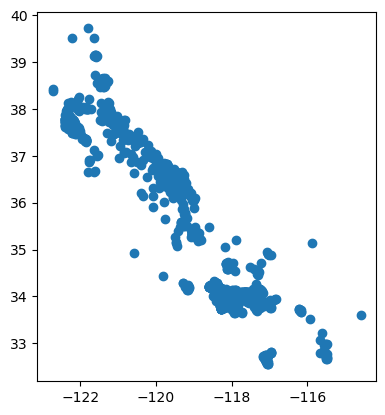

In [16]:
# confirm we have the right info (aka CA)
sb535_geo.plot()

#####  CalEnviroScreen Data
`ciscore` is the CalEnviroScore I believe, need to check meta

In [17]:
calenviro = gpd.read_file('../data/CalEnviroScreen/CES4 Final Shapefile.shp')

calenviro = to_snake_case(calenviro)

calenviro.head(1)

,tract,zip,county,approxloc,totpop19,ciscore,ciscorep,ozone,ozonep,pm2_5,...,elderly65,hispanic,white,africanam,nativeam,othermult,shape_leng,shape_area,aapi,geometry
0,6.083002e+09,93454,Santa Barbara,Santa Maria,4495,36.019653,69.162885,0.03419,10.566273,7.567724,...,12.5028,68.921,20.8899,0.4004,0.267,1.3126,6999.357689,2.847611e+06,8.2091,"POLYGON ((-39795.070 -341919.191, -38126.384 -341949.463, -38140.258 -343585.801, -38973.138 -343565.215, -39101.124 -343580.515, -39297.113 -343651.682, -39656.690 -343854.660, -39803.632 -343880.520, -39795.070 -341919.191))"


In [18]:
# crs config
calenviro = calenviro.to_crs(sb535_geo.crs)

# dtypes
calenviro.dtypes

tract          float64
zip              int64
county          object
approxloc       object
totpop19         int64
                ...   
othermult      float64
shape_leng     float64
shape_area     float64
aapi           float64
geometry      geometry
Length: 67, dtype: object

<Axes: >

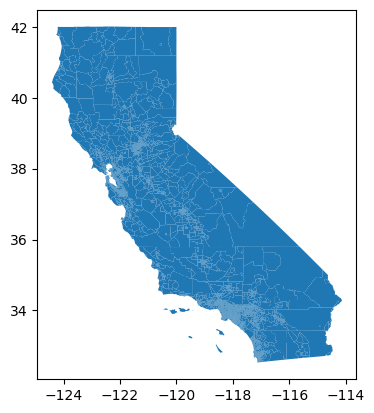

In [19]:
calenviro.plot()

### SD Climate Equity Index (SD_CEI)

In [20]:
sd_cei = gpd.read_file('../data/sd_climate_equity_index/City_of_San_Diego_CEI_2021_Revision.shp')

sd_cei = to_snake_case(sd_cei)

#sd_cei.head(3)

In [21]:
# match crs
sd_cei = sd_cei.to_crs(sb535_geo.crs)

# dtypes
sd_cei.dtypes

tract          float64
cei_score_       int64
cei_class_      object
cei_score1       int64
cei_class1      object
flood_risk     float64
fire_risk      float64
tree_cover     float64
urban_heat     float64
proximity_     float64
pesticide_     float64
drinking_w     float64
groundwate     float64
impaired_w     float64
air_qualit     float64
air_qual_1     float64
air_qual_2     float64
toxic_rele     float64
cleanup_si     float64
hazardous_     float64
solid_wast     float64
unemployme     float64
educationa     float64
linguistic     float64
digital_ac     float64
median_inc     float64
poverty_ra     float64
income_cha     float64
energy_cos     float64
solar_phot     float64
housing_co     float64
overcrowde     float64
pedestrian     float64
commute_bu     float64
transporta     float64
disability     float64
street_con     float64
bikeabilit     float64
access_to_     float64
traffic_de     float64
electric_v     float64
asthma_rat     float64
cancer_fat     float64
healthy_fo 

<Axes: >

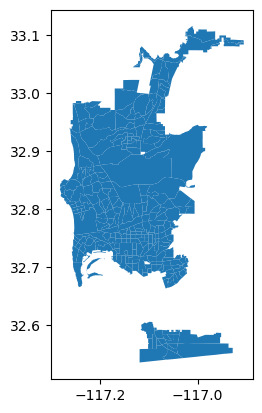

In [22]:
sd_cei.plot()

### EJScreen Tool Data

`id` is the tract_id

In [23]:
# read in data & clean colnames 
ejscreen = to_snake_case(pd.read_csv('../data/EJSCREEN_2023_Tracts_StatePct_with_AS_CNMI_GU_VI.csv'))

# isolate CA
ejscreen = ejscreen[ejscreen.state_name == 'California']

In [24]:
ejscreen

,oid_,id,state_name,st_abbrev,cnty_name,region,acstotpop,acsipovbas,acseducbas,acstothh,...,p_d2_pwdis,p_d5_pwdis,arealand,areawater,npl_cnt,tsdf_cnt,exceed_count_80,exceed_count_80_sup,shape_length,shape_area
4202,4203,6001400100,California,CA,Alameda,9,3324.0,3313.0,2513.0,1337.0,...,29.0,25.0,6945856.0,0.0,0,0,0,0.0,0.143536,0.000711
4203,4204,6001400200,California,CA,Alameda,9,2038.0,2038.0,1621.0,868.0,...,26.0,28.0,586560.0,0.0,0,0,0,0.0,0.041978,0.000060
4204,4205,6001400300,California,CA,Alameda,9,5449.0,5410.0,4358.0,2548.0,...,34.0,29.0,1110840.0,0.0,0,0,0,0.0,0.055377,0.000114
4205,4206,6001400400,California,CA,Alameda,9,4384.0,4384.0,3333.0,1826.0,...,32.0,27.0,716138.0,0.0,0,0,0,0.0,0.037278,0.000073
4206,4207,6001400500,California,CA,Alameda,9,4048.0,4039.0,3101.0,1673.0,...,50.0,43.0,591424.0,0.0,0,1,1,0.0,0.033224,0.000061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13326,13327,6115040902,California,CA,Yuba,9,1730.0,1041.0,516.0,357.0,...,54.0,56.0,93603063.0,240059.0,0,1,0,0.0,0.513671,0.009775
13327,13328,6115041001,California,CA,Yuba,9,3910.0,3901.0,2996.0,1407.0,...,27.0,41.0,275920634.0,1720985.0,0,0,0,0.0,0.892114,0.028971
13328,13329,6115041002,California,CA,Yuba,9,3408.0,3386.0,2567.0,1451.0,...,22.0,32.0,192476772.0,5206412.0,0,0,0,0.0,0.897197,0.020640
13329,13330,6115041101,California,CA,Yuba,9,2620.0,2620.0,1899.0,1128.0,...,34.0,58.0,464905359.0,16529900.0,0,0,0,0.0,1.580023,0.050389


In [25]:
ejscreen.columns.tolist()

ejscreen.dtypes

oid_                     int64
id                       int64
state_name              object
st_abbrev               object
cnty_name               object
                        ...   
tsdf_cnt                 int64
exceed_count_80          int64
exceed_count_80_sup    float64
shape_length           float64
shape_area             float64
Length: 126, dtype: object

In [26]:
ejscreen_geo.plot()

NameError: name 'ejscreen_geo' is not defined

### White House Map

In [ ]:
wh_map = gpd.read_file('../data/white_house_map/usa/usa.shp',
                       crs = sb535_geo.crs)

In [ ]:
wh_map = to_snake_case(wh_map)

wh_map.columns

Index(['geoid10', 'sf', 'cf', 'df_pfs', 'af_pfs', 'hdf_pfs', 'dsf_pfs',
       'ebf_pfs', 'ealr_pfs', 'eblr_pfs',
       ...
       'age_10', 'age_middle', 'age_old', 'ta_cou_116', 'ta_count_c',
       'ta_perc', 'ta_perc_fe', 'ui_exp', 'thrhld', 'geometry'],
      dtype='object', length=124)

In [ ]:
wh_ca = wh_map[wh_map.sf == 'California']

#wh_ca.head(1)

AttributeError: 'GeoDataFrame' object has no attribute 'sf'

<Axes: >

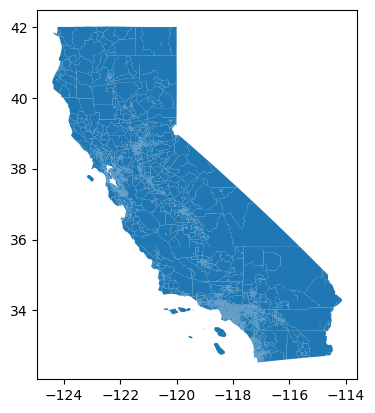

In [ ]:
wh_ca.plot()

### Climate and Vulnerability Factors

Air Conditioning lacks geolocations, so there's a strong chance we will have to rely on `county_fips` or `geotypevalue` matching from merging the datasets with one that contains coordinates.

Plan is to likely combine all metric data into a df to then combine with a single df with geolocations and `county_fips`, then plot to check accuracy

In [ ]:
air_conditioning = pd.read_excel('../data/Climate_Vulnerability_Metric_Indicators/BRACE_AirConditioning_797_CO_RE_CA.xlsx', sheet_name=None)
 
# collect Clim. Vuln. Factor air conditioning sheet names
ac_sheetnames = list(air_conditioning.keys())

ac_sheetnames

['ReadMe',
 'Data',
 'DataDictionary',
 'DataFilteringInstructions',
 'AIR_Regions']

In [ ]:
# read in sheets as df
ac_README = air_conditioning[ac_sheetnames[0]]

ac_data = air_conditioning[ac_sheetnames[1]]

ac_dict = air_conditioning[ac_sheetnames[2]]

In [ ]:
ac_README

,Term,Title,Description
0,Project,California Building Resilience Against Climate Effects (CalBRACE) Project,NaN
1,Indicator Name,Air Conditioning,NaN
2,Indicator Short Name,Percent of households without air conditioning,NaN
3,Data Source,2009 Residential Appliance Saturation Study (RASS). (https://websafe.kemainc.com/RASS2009/Default.aspx),NaN
4,Creator,CalBRACE @cdph.ca.gov,NaN
5,Version,2016-12-13 00:00:00,NaN
6,Documentation,< insert link to narrative >,NaN
7,Contents.Data,Data,"Data on the percent of households with air conditioning for California at multiple geographical levels: county (CO), region (RE), and state (CA)"
8,Contents.DataDictionary,DataDictionary,Description of all of the variables in the Data tab
9,Contents.DataFilteringInstructions,DataFilteringInstructions,Instructions on how to apply filters to navigate the data in the file


In [ ]:
ac_data.columns

Index(['county_name', 'ind_id', 'ind_definition', 'reportyear',
       'race_eth_code', 'race_eth_name', 'geotype', 'geotypevalue', 'geoname',
       'county_fips', 'strata_one_code', 'strata_one_name', 'strata_two_code',
       'strata_two_name', 'numerator', 'denominator', 'estimate', 'LL_95CI',
       'UL_95CI', 'SE', 'RSE', 'CA_decile', 'CA_RR', 'version', 'region_code',
       'region_name'],
      dtype='object')

In [ ]:
ac_dict

,Name,Definition,Type,Coding
0,ind_id,Indicator ID,N,26
1,ind_definition,Definition of indicator in plain language,T,Free text
2,reportyear,Year that the indicator was reported,T,2009
3,race_eth_code,numeric code for a race/ethnicity group,T,1 = American Indian; 2 = Asian or Pacific; 3 = Black or African American; 4 = Hispanic or Latino; 6 = White or Caucasian; 8 = Other;
4,race_eth_name,Name of race/ethnic group,T,American Indian; Asian or Pacific; Black or African American; Hispanic or Latino; White or Caucasian; Other;
5,geotype,Type of geographic unit,T,CO County; RE Region; CA State
6,geotypevalue,Value of geographic unit,N,FIPS ID; region id
7,geoname,Name of geographic unit,T,"county, region name, state"
8,county_name,Name of county that geotype is in,T,NaN
9,county_fips,FIPS code of county that geotype is in,T,2-digit census state code (06) plus 3-digit census county code


In [ ]:
ac_data.county_fips

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
       ...  
74    6107.0
75    6109.0
76    6111.0
77    6113.0
78    6115.0
Name: county_fips, Length: 79, dtype: float64

In [ ]:
folder = '../data/Climate_Vulnerability_Metric_Indicators/'
combo_metric_df = pd.DataFrame()

for file_name in os.listdir(folder):
    if file_name.endswith('.xlsx') or file_name.endswith('.XLSX'):
        file_path = os.path.join(folder, file_name)
        
        # Read Excel file with all sheets into a dictionary
        temp_df = pd.read_excel(file_path, sheet_name=None)
        
        # Assuming you want to extract the second sheet from each file
        for sheet_name, df in temp_df.items():
            if sheet_name == 'Data':  # Adjust sheet name as needed
                # Concatenate to the combined DataFrame
                combo_metric_df = pd.concat([combo_metric_df, df], ignore_index=True)

# Print the concatenated DataFrame if it's not empty
if not combo_metric_df.empty:
    print(combo_metric_df)
else:
    print("No data found or failed to concatenate properly.")


/Users/sofiaingersoll/anaconda3/envs/eds-env/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/Users/sofiaingersoll/anaconda3/envs/eds-env/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


         ind_id                                     ind_definition reportyear  \
0         355.0  Percent of population age 25 and up with a fou...       2000   
1         355.0  Percent of population age 25 and up with a fou...       2000   
2         355.0  Percent of population age 25 and up with a fou...       2000   
3         355.0  Percent of population age 25 and up with a fou...       2000   
4         355.0  Percent of population age 25 and up with a fou...       2000   
...         ...                                                ...        ...   
1442521   187.0     Percent of population without health insurance       2015   
1442522   187.0     Percent of population without health insurance       2015   
1442523   187.0     Percent of population without health insurance       2015   
1442524   187.0     Percent of population without health insurance       2015   
1442525   187.0     Percent of population without health insurance       2015   

         race_eth_code race

In [ ]:
# let's make sure we loaded the right amount of xlsx
len(combo_metric_df.ind_definition.unique())

21

In [ ]:
# and double check the indicators are included as expected
# bc we got more than expected it should be 19
# the duplicates we're seeing are caused by spaces in the text
# Percent of households with no one aged >14 years speaking English',
# Percent of population employed and aged >16 working outdoors'
combo_metric_df.ind_definition.unique()

array(['Percent of population age 25 and up with a four-year college degree or higher',
       'Percent of the land area covered by impervious surfaces',
       'Average Daily Maximum Ozone Concentration',
       'Percent of households with air conditioning', nan,
       'Projected number of extreme heat days (per year)',
       'Percent of households with no vehicle ownership',
       'Percent of population with a disability',
       'Percent of population by race and ethnicity',
       'Population living in sea level rise inundation areas',
       'Percent without tree canopy coverage',
       'Annual Mean Ambient Concentration of Fine Particulate Matter (PM2.5)',
       'Percent of population aged 65 years or older',
       'Percent of households with no one aged >14 years speaking English',
       'Percent of households with no one aged > 14 years speaking English',
       'Percent of population age less than 5 years',
       'Percent of population currently living in very high wil

In [ ]:
combo_metric_df.columns

Index(['ind_id', 'ind_definition', 'reportyear', 'race_eth_code',
       'race_eth_name', 'geotype', 'geotypevalue', 'geoname', 'county_name',
       'county_fips', 'region_name', 'region_code', 'strata_one_code',
       'strata_one_name', 'strata_two_code', 'strata_two_name', 'numerator',
       'denominator', 'estimate', 'LL_95CI', 'UL_95CI', 'SE', 'RSE',
       'CA_decile', 'CA_RR', 'version', 'Geoname', 'County_Name',
       'COUNTY_FIPS', 'se', 'Region_name', 'Region_code'],
      dtype='object')

In [ ]:
# load drought metric NETCDF data
# fabulous, it contains geolocation data
# let's merge this with the combo metric data and see how it plots
drought_path = os.path.join(folder, 'pdsi_current_PRISM.nc')

drought = xr.open_dataset(drought_path)
drought_df = drought.to_dataframe()

# okay lat/long are indexes, this is an issue for combining
drought_df = drought_df.reset_index()
drought_df

# mental note to check later: how is day going to influence the join?
# i think should be fine bc of year vs day but there's no way of matching the og planned columns to this df
# need to make a db schema to visualize how i can relate these df properly
# going to just go through the hairy wkflw for now and correct these errors tomorrow 

,longitude,latitude,day,data
0,-125.020836,24.062500,2024-06-15,NaN
1,-125.020836,24.104166,2024-06-15,NaN
2,-125.020836,24.145834,2024-06-15,NaN
3,-125.020836,24.187500,2024-06-15,NaN
4,-125.020836,24.229166,2024-06-15,NaN
...,...,...,...,...
872500,-66.520836,49.729168,2024-06-15,NaN
872501,-66.520836,49.770832,2024-06-15,NaN
872502,-66.520836,49.812500,2024-06-15,NaN
872503,-66.520836,49.854168,2024-06-15,NaN


In [ ]:
drought_geo = gpd.GeoDataFrame(drought,
                               geometry = gpd.points_from_xy(drought['longitude'], drought['latitude']),
                               crs = 'EPSG:4326')

drought_geo.plot()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1405,) and arg 1 with shape (621,).

In [ ]:
# combine df
combo_metrics_geo = pd.concat([combo_metric_df, drought_df], ignore_index=True)

#combo_metrics_geo = pd.concat([combo_metric_df, drought_df])

combo_metrics_geo

,ind_id,ind_definition,reportyear,race_eth_code,race_eth_name,geotype,geotypevalue,geoname,county_name,county_fips,...,County_FIPS,ll_95ci,ul_95ci,rse,ca_decile,ca_rr,longitude,latitude,day,data
0,355.0,Percent of population age 25 and up with a fou...,2000,3.0,AfricanAm,CA,6.0,California,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
1,355.0,Percent of population age 25 and up with a fou...,2000,1.0,AIAN,CA,6.0,California,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
2,355.0,Percent of population age 25 and up with a fou...,2000,2.0,Asian,CA,6.0,California,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
3,355.0,Percent of population age 25 and up with a fou...,2000,4.0,Latino,CA,6.0,California,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
4,355.0,Percent of population age 25 and up with a fou...,2000,7.0,Multiple,CA,6.0,California,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1442422,187.0,Percent of population without health insurance,2015,5.0,NHOPI,CA,6.0,California,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
1442423,187.0,Percent of population without health insurance,2015,3.0,AfricanAm,CA,6.0,California,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
1442424,187.0,Percent of population without health insurance,2015,2.0,Asian,CA,6.0,California,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
1442425,187.0,Percent of population without health insurance,2015,6.0,White,CA,6.0,California,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN


/var/folders/n4/2w_c819n7nv4fr_mvn5wpsnc0000gn/T/ipykernel_49066/2233384457.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


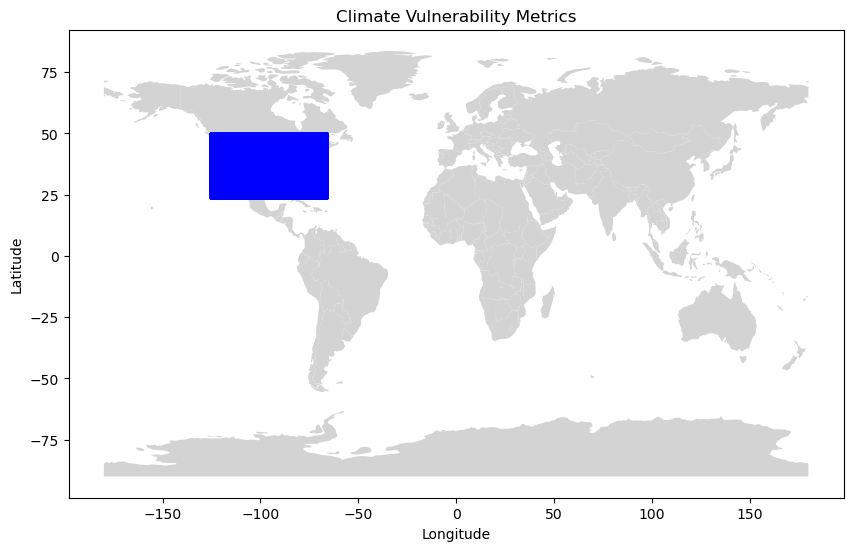

In [ ]:
# make it a geo object for mapping
combo_metrics_geo = gpd.GeoDataFrame(combo_metrics_geo, 
                                     geometry = gpd.points_from_xy(combo_metrics_geo['longitude'], combo_metrics_geo['latitude']),
                                     crs = 'EPSG:4326')

fig, ax = plt.subplots(figsize=(10, 10))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgrey')

combo_metrics_geo.plot(ax=ax, marker='o', color='blue', markersize=5, alpha=0.5)
plt.title('Climate Vulnerability Metrics')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
# isolate CA
ca_metrics_geo = combo_metrics_geo[combo_metrics_geo.geotype == 'CA']

ca_metrics_geo = ca_metrics_geo.dropna(subset=['longitude', 'latitude'])

ca_metrics_geo = ca_metrics_geo[ca_metrics_geo['longitude'].apply(lambda x: np.isfinite(x))]
ca_metrics_geo = ca_metrics_geo[ca_metrics_geo['latitude'].apply(lambda x: np.isfinite(x))]

ca_metrics_geo = gpd.GeoDataFrame(ca_metrics_geo, 
                                     geometry = gpd.points_from_xy(ca_metrics_geo['longitude'], ca_metrics_geo['latitude']),
                                     crs = 'EPSG:4326')


ca_metrics_geo.plot()

KeyError: 'latitude'

### DOE's Energy Justice Mapping Tool - Disadvantaged Communities Reporter (EJMT)

In [ ]:
doe_ejmt = gpd.read_file('../data/DOE_EJ_mapping_tool/DAC Shapefiles (v2022c).shp',
                         crs = sb535_geo.crs)

doe_ejmt = to_snake_case(doe_ejmt)

doe_ejmt_ca = doe_ejmt[doe_ejmt.stateabb == 'CA']

doe_ejmt_ca

,geoid,city,county,stateabb,countyfips,cbsa,cbsaname,statefips,population,dacsts,...,disablpct,incplmbpct,snglpntpct,mobilhmpct,nongridpct,lesshspct,lowincfpct,lowincapct,eal_npctl,geometry
263,06003010000,Markleeville,"Alpine County, CA",CA,6003,99999,None,6,1039.0,0,...,0.159769,0.000000,0.386503,0.017946,0.848571,0.088312,0.388835,0.232877,98.801193,"POLYGON ((-13366398.426 4679189.192, -13365864..."
264,06007001300,Chico,"Butte County, CA",CA,6007,17020,"Chico, CA",6,3689.0,0,...,0.173486,0.000000,0.485294,0.034864,0.032665,0.200159,0.514184,0.539340,91.930051,"POLYGON ((-13562009.036 4826320.661, -13561775..."
266,06015000203,Klamath,"Del Norte County, CA",CA,6015,18860,"Crescent City, CA",6,1251.0,0,...,0.301920,0.008811,0.634615,0.432810,0.607930,0.181319,0.539267,0.416000,75.575688,"POLYGON ((-13820782.324 5120426.256, -13819546..."
267,06023010102,Willow Creek,"Humboldt County, CA",CA,6023,21700,"Eureka-Arcata, CA",6,2423.0,0,...,0.210196,0.012333,0.100683,0.073875,0.770812,0.064706,0.385290,0.447674,84.305531,"POLYGON ((-13807602.096 5081143.191, -13803750..."
268,06023940000,None,"Humboldt County, CA",CA,6023,21700,"Eureka-Arcata, CA",6,3263.0,0,...,0.205648,0.062147,0.740831,0.334879,0.841808,0.120198,0.651013,0.383959,70.934437,"POLYGON ((-13782844.641 5035659.850, -13773282..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71260,06071010417,Morongo Valley,"San Bernardino County, CA",CA,6071,40140,"Riverside-San Bernardino-Ontario, CA",6,2931.0,0,...,0.176731,0.000000,0.309859,0.075137,0.258493,0.076227,0.397134,0.277683,89.126878,"POLYGON ((-12982335.051 4038245.509, -12982079..."
71262,06071010415,Twentynine Palms,"San Bernardino County, CA",CA,6071,40140,"Riverside-San Bernardino-Ontario, CA",6,5316.0,0,...,0.232675,0.000000,0.465098,0.015801,0.048458,0.147978,0.297216,0.283658,88.066924,"POLYGON ((-12924994.381 4051867.053, -12924972..."
71264,06071010421,Twentynine Palms,"San Bernardino County, CA",CA,6071,40140,"Riverside-San Bernardino-Ontario, CA",6,6003.0,0,...,0.200203,0.012821,0.434954,0.017824,0.074204,0.084351,0.630327,0.417069,90.001237,"POLYGON ((-12921899.700 4045531.610, -12921576..."
72940,06059990100,None,"Orange County, CA",CA,6059,31080,"Los Angeles-Long Beach-Anaheim, CA",6,0.0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,None


<Axes: >

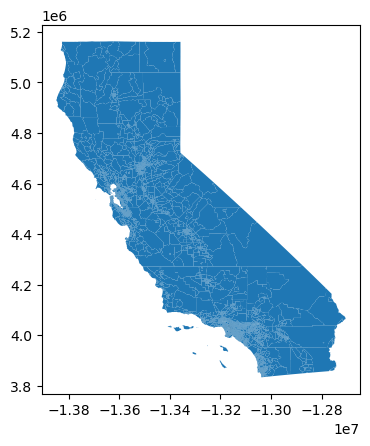

In [ ]:
doe_ejmt_ca.plot()

### CDC's Environmental Justice Index (EJI)

location = Census Tract 4001; Alameda County; California

In [ ]:
cdc_eji = to_snake_case(pd.read_csv('../data/CDC_Index/California_EJ.csv'))

cdc_eji_ca = cdc_eji[cdc_eji.stateabbr == 'CA']

In [ ]:
cdc_eji_ca_geo = gpd.GeoDataFrame(cdc_eji_ca)

# let's see if there is a geometry column if we don't set it 
# obvi no, so the cdc data will need to be added to the schema assignment plan 
# these cdc won't be included in the simple_wkflw.ipynb outputs
cdc_eji_ca_geo.geometry

AttributeError: You are calling a geospatial method on the GeoDataFrame, but the active geometry column to use has not been set. 
There are no existing columns with geometry data type. You can add a geometry column as the active geometry column with df.set_geometry. 

In [ ]:
cdc_eji_ca.plot()

### CDC's Social Vulnerability Index (SVI)
`fips` needs to be put in sci-not

In [ ]:
cdc_svi = to_snake_case(pd.read_csv('../data/CDC_Index/California_SVI.csv'))

cdc_svi
#cdc_svi_ca = cdc_svi[cdc_svi.st_abbr == 'CA']

,st,state,st_abbr,stcnty,county,fips,location,area_sqmi,e_totpop,m_totpop,...,ep_asian,mp_asian,ep_aian,mp_aian,ep_nhpi,mp_nhpi,ep_twomore,mp_twomore,ep_otherrace,mp_otherrace
0,6,California,CA,6001,Alameda County,6001400100,Census Tract 4001; Alameda County; California,2.681809,3269,452,...,14.6,3.7,0.0,1.2,0.0,1.2,5.3,2.7,0.8,0.9
1,6,California,CA,6001,Alameda County,6001400200,Census Tract 4002; Alameda County; California,0.226472,2147,201,...,11.7,4.5,0.4,0.7,0.0,1.8,8.5,3.4,0.4,0.5
2,6,California,CA,6001,Alameda County,6001400300,Census Tract 4003; Alameda County; California,0.428898,5619,571,...,11.3,3.3,0.5,0.5,0.0,0.7,9.1,4.8,1.1,1.0
3,6,California,CA,6001,Alameda County,6001400400,Census Tract 4004; Alameda County; California,0.276502,4278,598,...,8.7,2.7,0.5,0.7,0.0,0.9,7.7,3.1,0.2,0.2
4,6,California,CA,6001,Alameda County,6001400500,Census Tract 4005; Alameda County; California,0.228350,3949,737,...,9.4,4.5,0.1,0.2,0.2,0.3,8.3,5.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9104,6,California,CA,6115,Yuba County,6115040902,Census Tract 409.02; Yuba County; California,36.140330,1868,173,...,4.4,3.1,0.2,0.3,0.5,0.8,4.0,2.8,0.0,2.1
9105,6,California,CA,6115,Yuba County,6115041001,Census Tract 410.01; Yuba County; California,106.533509,3672,751,...,0.0,1.1,0.3,0.7,0.0,1.1,4.9,3.6,0.0,1.1
9106,6,California,CA,6115,Yuba County,6115041002,Census Tract 410.02; Yuba County; California,74.315667,3417,584,...,0.8,1.2,0.0,1.2,0.3,0.6,11.4,7.6,0.0,1.2
9107,6,California,CA,6115,Yuba County,6115041101,Census Tract 411.01; Yuba County; California,179.500889,2288,718,...,0.0,1.7,0.7,1.2,0.0,0.1,4.9,2.8,0.0,1.7


### US Climate Vulnerability Index: Overall Climate Vulnerability in The U.S.

okay I took a png of the map I was interested in and converted it into a tif, so the data was not properly adheased for parsing and the coordinate boundaries and resolution need to be defined. I believe that would resolve the error below. Saving for round 2 after schema is corrected.


In [ ]:
us_overall_cv = rioxr.open_rasterio('../data/us_overall_climate_vulnerability.tif',
                                    crs = sb535_geo.crs)
us_overall_cv

/Users/sofiaingersoll/anaconda3/envs/eds-env/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


<xarray.DataArray (band: 4, y: 2940, x: 4000)>
[47040000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 0.5 1.5 2.5 3.5 ... 3.998e+03 3.998e+03 4e+03
  * y            (y) float64 0.5 1.5 2.5 3.5 ... 2.938e+03 2.938e+03 2.94e+03
    spatial_ref  int64 0
Attributes:
    TIFFTAG_XRESOLUTION:  96
    TIFFTAG_YRESOLUTION:  96
    scale_factor:         1.0
    add_offset:           0.0

(array([  106553.,   476592.,   597541.,   563441.,   448098.,   482266.,
          710691.,   951070., 18057794., 24645954.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

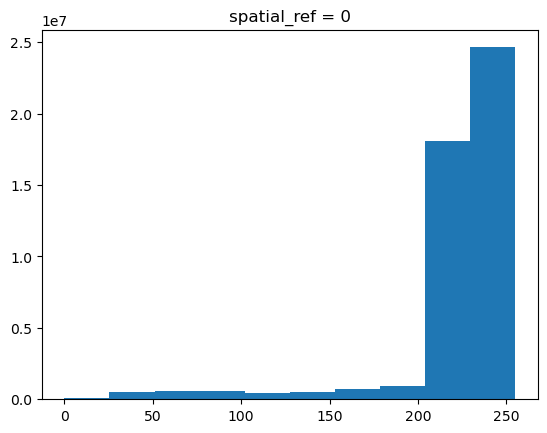

In [ ]:
us_overall_cv.plot()

#### Mapping

#### Interpretting

Include explanation of CalEnviroScreen Scores